In [22]:
# !cp /content/drive/MyDrive/vandecia/denseGroupTPE/database.zip .

In [23]:
# !unzip database.zip

In [24]:
!pip install hyperopt
!pip install pymongo
!pip install nbconvert
!pip install pydot graphviz

In [25]:
!mkdir results

mkdir: não foi possível criar o diretório “results”: Arquivo existe


In [26]:
import numpy as np
import sklearn as sk
import os
from sklearn.model_selection import train_test_split
import random
import glob
from sklearn.metrics import accuracy_score # deu problema no ultimo treino e agora adicionei isso para que a variavel acc funcione 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from keras.models import Model
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
from keras import layers
from keras.optimizers import SGD, Adam
from sklearn import metrics
from keras import metrics
from keras.models import load_model, Model
from tensorflow.keras.utils import plot_model

from hyperopt import hp
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK
from hyperopt import STATUS_OK, STATUS_FAIL


import json
from bson import json_util

import keras.backend as K
from sklearn.utils import class_weight
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score

import traceback
import pickle
import uuid

from datetime import datetime


In [1]:
!python -m jupyter nbconvert --to script "*.ipynb"

[NbConvertApp] Converting notebook 9_Otimizando_uma_densenet_from_scratch_[NAS].ipynb to script
[NbConvertApp] Writing 17347 bytes to 9_Otimizando_uma_densenet_from_scratch_[NAS].py
[NbConvertApp] Converting notebook Teste_Dense_Scratch_Geraldo.ipynb to script
[NbConvertApp] Writing 20874 bytes to Teste_Dense_Scratch_Geraldo.py


In [29]:
#define o tamanho padrão das imagens que serão passadas na rede, sendo que a mesma aceita imagens maiores que o padrão definido da VGG16 (255x255)
img_width = 128
img_height =  128
batch_size = 8 #batch_size para o treino

#define o batch_size de validação, das imagens de acordo com a memória disponivél na máquina
batch_size_val = 1

#define as épocas
epochs = 10

class_weight = {0: 1.48, 1: 4.14, 2:11.49}
# class_weight = {0: 1, 1: 1, 2:1}

RESULTS_DIR = "results/" #pasta para salvar os resultados dos treinamentos

train_data_dir = "database/split1/train"
validation_data_dir = "database/split1/val"
test_data_dir = "database/split1/test"

num_classes_exp = 3


space = {
    'num_blocks': hp.choice('num_blocks', [3]),
    'num_layers_per_block' : hp.choice('num_layers_per_block', [2]),
    'growth_rate': hp.choice('growth_rate', [32]),
    'dropout_rate' : hp.uniform('dropout_rate', 0.2, 0.35),
    'compress_factor' : hp.choice('compress_factor', [0.5]),
    'num_filters' : hp.choice('num_filters', [64])
}




#DataGenerator utilizado para fazer o augmentation on the batch
datagen = ImageDataGenerator(rescale=1., # era assim antes de adicionar o clahe
    featurewise_center=True,
    rotation_range=10,
    width_shift_range=.1,
    height_shift_range=.1,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="reflect") #generator de treino

validgen = ImageDataGenerator(rescale=1., featurewise_center=True) #generator de teste e validação, evita-se realizar alterações nas imagens # era assim antes de adicionar o clahe

#como as imagens apresentam um tamanho maior que o padrão, deve-se fazer uma normalização das mesmas para que sejam aceitas na rede
# datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)
# validgen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)


#definindo os geradores para cada pasta
train_gen = datagen.flow_from_directory( #generator para treino
    train_data_dir,
    target_size=(img_height, img_width),
    # color_mode='grayscale',
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

val_gen = validgen.flow_from_directory( #generator para validação
    validation_data_dir,
    target_size=(img_height, img_width),
    # color_mode='grayscale',
    batch_size=batch_size_val,
    class_mode="categorical",
    shuffle=True)

test_gen = validgen.flow_from_directory( #generator para teste
    test_data_dir,
    target_size=(img_height, img_width),
    # color_mode='grayscale',
    batch_size=batch_size_val,
    class_mode="categorical",
    shuffle=False)


#pega a quantidade de amostras de cada generator
train_samples = len(train_gen.filenames)
validation_samples = len(val_gen.filenames)
test_samples = len(test_gen.filenames)

Found 9697 images belonging to 3 classes.
Found 2425 images belonging to 3 classes.
Found 3031 images belonging to 3 classes.


In [ ]:

def apply_clahe(img):
    """Versão mais robusta do CLAHE"""
    try:
        # Converte para uint8 se necessário
        if img.dtype != np.uint8:
            if img.max() <= 1.0:
                img = (img * 255).astype(np.uint8)
            else:
                img = img.astype(np.uint8)
        
        # Converte para LAB
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l_channel = lab[:,:,0]
        
        # Aplica CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl = clahe.apply(l_channel)
        
        # Junta os canais
        lab[:,:,0] = cl
        final = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        
        # Normaliza
        return final.astype(np.float32) / 255.0
    
    except Exception as e:
        print(f"Error applying CLAHE: {e}")
        return img  # Retorna a imagem original em caso de erro

In [ ]:
import cv2
import matplotlib.pyplot as plt

def preprocess_with_clahe(image):
    """Wrapper para aplicar CLAHE dentro do ImageDataGenerator"""
    # Garante que a imagem está no formato correto (0-255)
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)
    
    # Aplica CLAHE
    image = apply_clahe(image)
    
    # Garante que retorna no formato esperado (0-1)
    return image.astype(np.float32) / 255.0

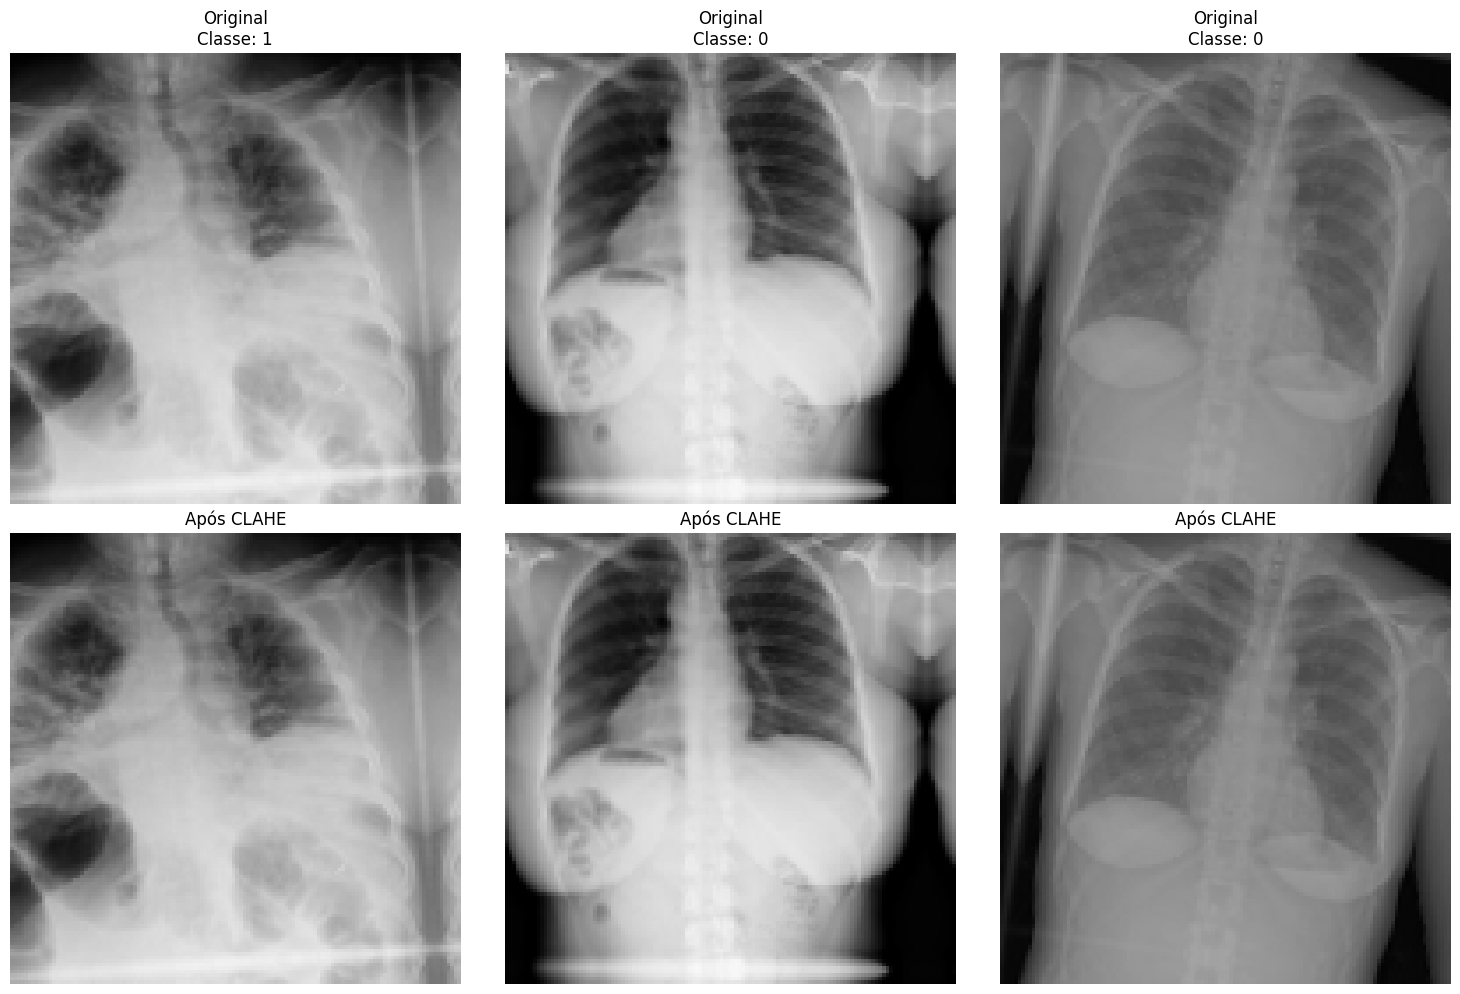

In [31]:
def visualize_preprocessing(generator, num_images=3):
    """Visualiza imagens antes e depois do pré-processamento"""
    images, labels = next(generator)
    class_names = list(generator.class_indices.keys())
    
    plt.figure(figsize=(15, 10))
    
    for i in range(min(num_images, len(images))):
        # Imagem original (após outras transformações mas antes do CLAHE)
        orig_image = images[i].copy()
        if orig_image.mean() < 1:
            orig_image = orig_image * 255
        orig_image = np.clip(orig_image, 0, 255).astype('uint8')
        
        # Imagem após CLAHE (já aplicado pelo generator)
        clahe_image = images[i]
        if clahe_image.mean() < 1:
            clahe_image = clahe_image * 255
        clahe_image = np.clip(clahe_image, 0, 255).astype('uint8')
        
        label_idx = np.argmax(labels[i])
        label_name = class_names[label_idx]
        
        # Plota original
        plt.subplot(2, num_images, i+1)
        plt.imshow(orig_image)
        plt.title(f'Original\nClasse: {label_name}')
        plt.axis('off')
        
        # Plota CLAHE
        plt.subplot(2, num_images, num_images+i+1)
        plt.imshow(clahe_image)
        plt.title('Após CLAHE')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Teste a visualização
visualize_preprocessing(train_gen, num_images=3)

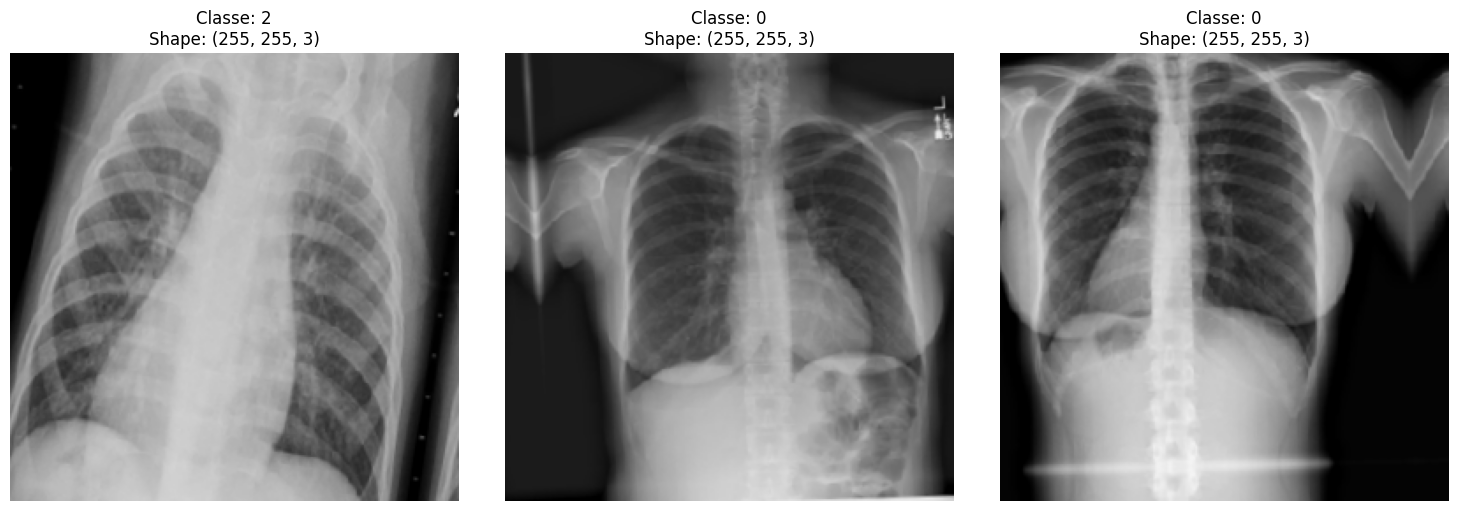

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_training_images(generator, num_images=3):
    """
    Visualiza imagens do gerador de treino
    
    Args:
        generator: Seu ImageDataGenerator (train_gen no seu caso)
        num_images: Número de imagens a mostrar
    """
    # Obtém um batch de imagens do generator
    images, labels = next(generator)
    
    # Nomes das classes (pega o mapeamento do generator)
    class_names = list(generator.class_indices.keys())
    
    # Configura o plot
    plt.figure(figsize=(15, 5))
    
    for i in range(min(num_images, len(images))):
        # Desnormaliza a imagem (se foi normalizada)
        image = images[i]
        if image.mean() < 1:  # Se os valores estiverem entre 0 e 1
            image = image * 255
        image = np.clip(image, 0, 255).astype('uint8')
        
        # Obtém a label verdadeira
        label_idx = np.argmax(labels[i])
        label_name = class_names[label_idx]
        
        # Plota a imagem
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.title(f'Classe: {label_name}\nShape: {image.shape}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Uso: visualize 3 imagens do conjunto de treino
visualize_training_images(train_gen, num_images=3)

In [15]:
tf.keras.backend.clear_session()

def keras_model_memory_usage_in_bytes(model, *, batch_size: int):

    """
    Return the estimated memory usage of a given Keras model in bytes.
    This includes the model weights and layers, but excludes the dataset.

    The model shapes are multipled by the batch size, but the weights are not.

    Args:
        model: A Keras model.
        batch_size: The batch size you intend to run the model with. If you
            have already specified the batch size in the model itself, then
            pass `1` as the argument here.
    Returns:
        An estimate of the Keras model's memory usage in bytes.

    """
    default_dtype = tf.keras.backend.floatx()
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            internal_model_mem_count += keras_model_memory_usage_in_bytes(
                layer, batch_size=batch_size
            )
        single_layer_mem = tf.as_dtype(layer.dtype or default_dtype).size
        out_shape = layer.output_shape
        if isinstance(out_shape, list):
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.trainable_weights]
    )
    non_trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.non_trainable_weights]
    )

    total_memory = (
        batch_size * shapes_mem_count
        + internal_model_mem_count
        + trainable_count
        + non_trainable_count
    )
    return total_memory

In [150]:
def save_json_result(model_name, result):
    """Save json to a directory and a filename."""
    result_name = '{}.txt.json'.format(model_name)
    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
    with open(os.path.join(RESULTS_DIR, result_name), 'w') as f:
        json.dump(
            result, f,
            default=json_util.default, sort_keys=True,
            indent=4, separators=(',', ': ')
        )


In [151]:
import numpy as np
import os
from keras.models import Model
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
from keras import layers
from keras.optimizers import SGD, Adam
from sklearn import metrics
from keras import metrics

eps = 1.1e-5
'''
def H( inputs, num_filters , dropout_rate ):
    x = layers.BatchNormalization( epsilon=eps )( inputs )
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D((1, 1))(x)
    x = layers.SeparableConv2D(num_filters, kernel_size=(3, 3), use_bias=False , kernel_initializer='he_normal' )(x)
    x = layers.Dropout(rate=dropout_rate )(x)
    return x
'''
def H( inputs, num_filters , dropout_rate ):
    x = layers.BatchNormalization( epsilon=eps )( inputs )
    x = layers.Activation('relu')(x)

    out_conv = []
    for i in [(1,1),(3,3),(5,5),(0,0)]:
        p = x
        if i == (1,1):
                p = layers.Conv2D(num_filters, (1,1), padding="same",activation="relu")(p)
                out_conv.append(layers.Conv2D(num_filters, (1,1), padding="same",activation="relu")(p))
        elif i == (0,0):
                p = layers.MaxPool2D(pool_size=(2, 2), padding="same",strides=(1,1))(p)
                out_conv.append(layers.Conv2D(num_filters, (1,1), padding="same",activation="relu")(p))
        else:
                p = layers.Conv2D(num_filters, (1,1), padding="same",activation="relu")(p)
                p = layers.SeparableConv2D(num_filters, i, padding="same",activation="relu")(p)
                out_conv.append(layers.SeparableConv2D(num_filters, i, padding="same",activation="relu")(p))

    x = layers.concatenate(out_conv, axis = -1)
    x = layers.Dropout(rate=dropout_rate )(x)
    return x

def transition(inputs, num_filters , compression_factor , dropout_rate ):
    # compression_factor is the 'θ'
    x = layers.BatchNormalization( epsilon=eps )(inputs)
    x = layers.Activation('relu')(x)
    num_feature_maps = inputs.shape[1] # The value of 'm'

    x = layers.Conv2D(int(np.floor(num_feature_maps * compression_factor)) ,
                               kernel_size=(1, 1), use_bias=False, padding='same' , kernel_initializer='he_normal')(x)
    x = layers.Dropout(rate=dropout_rate)(x)

    x = layers.AveragePooling2D(pool_size=(2, 2))(x)
    return x

def dense_block( inputs, num_layers, num_filters, growth_rate , dropout_rate ):
    for i in range(num_layers): # num_layers is the value of 'l'
        conv_outputs = H(inputs, num_filters , dropout_rate )
        inputs = layers.Concatenate()([conv_outputs, inputs])
        num_filters += growth_rate # To increase the number of filters for each layer.
    return inputs, num_filters

def get_model(input_shape,
           num_blocks,
           num_layers_per_block,
           growth_rate,
           dropout_rate,
           compress_factor,
           num_filters,
           num_classes):
    '''
    input_shape = ( 32 , 32 , 3 )
    num_blocks = 3
    num_layers_per_block = 4
    growth_rate = 16
    dropout_rate = 0.4
    compress_factor = 0.5

    num_filters = 16
    '''

    inputs = layers.Input( shape=input_shape )
    x = layers.Conv2D( num_filters , kernel_size=( 3 , 3 ) , padding="same", use_bias=False, kernel_initializer='he_normal')( inputs )
    for i in range( num_blocks ):
        x, num_filters = dense_block( x, num_layers_per_block , num_filters, growth_rate , dropout_rate )
        x = transition(x, num_filters , compress_factor , dropout_rate )

    x = layers.GlobalAveragePooling2D()( x )
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense( num_classes )( x )
    outputs = layers.Activation( 'softmax' )( x )

    model = Model( inputs , outputs )
    model.compile( loss='categorical_crossentropy' ,optimizer=Adam(),
                    metrics=[ 'accuracy',
                              metrics.Recall(thresholds=0.5, class_id=0,name='r_normal'),
                              metrics.Recall(thresholds=0.5, class_id=1,name='r_covid'),
                              metrics.Recall(thresholds=0.5, class_id=2,name='r_viral')])
    return model

In [ ]:
def build_and_train(hype_space):
    print (hype_space)

    model_final = get_model(input_shape=(img_width, img_height, 3),
            num_blocks = int(hype_space['num_blocks']),
            num_layers_per_block = int(hype_space['num_layers_per_block']),
            growth_rate = int(hype_space['growth_rate']),
            dropout_rate = hype_space['dropout_rate'],
            compress_factor = hype_space['compress_factor'],
            num_filters = hype_space['num_filters'],
            num_classes = num_classes_exp)
# ----------------------------------------------------------------------------
    model_size = keras_model_memory_usage_in_bytes(model = model_final,
                       batch_size = batch_size)
    model_size = model_size/1000000000

    #print("Model size: " + str(model_size) )
    if (model_size > 10.5):
        model_name = "model_" + str(uuid.uuid4())[:5]
        result = {
            'space': hype_space,
            'status': STATUS_FAIL
        }
        return model_final, model_name, result
    
    # nova alteracao aquiiiii 10/04
    weights_file = 'weights_best_etapa1.keras'
    if os.path.exists(weights_file):
        print("Carregando pesos pré-existentes...")
        model_final = load_model(weights_file)
    else:
        print("Nenhum peso encontrado. Treinando do zero...")


    # model_final = load_model('weights_best_etapa1.keras')

# ----------------------------------------------------------------------------


    #inicio da fase de treino
    #as imagens são passadas na rede
    early_stopping = EarlyStopping(monitor='loss', patience=4,
                                    verbose=1, mode='auto')
    checkpoint = ModelCheckpoint('weights_best_etapa1.keras', monitor='loss',
                                verbose=1,
                                save_best_only=True, mode='auto')

    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, verbose=1)

    model_final.fit(train_gen,
                                epochs=epochs,
                                steps_per_epoch=int(train_samples/batch_size),
                                validation_data=test_gen,
                                validation_steps=batch_size_val,
                                class_weight = class_weight,
                                verbose=1, callbacks=[early_stopping,checkpoint,reduce_lr])

    preds = model_final.predict(test_gen, test_samples) #realiza o teste de classificação das imagens na rede
    y_pred = np.argmax(preds, axis=1)
    #print(classification_report(test_gen.classes, y_pred))#, target_names=target_names))
    acc = accuracy_score(test_gen.classes, y_pred) #calcula o acurácia era metrics.accuracy_score....
    class_report = classification_report(test_gen.classes, y_pred, output_dict=True)#, target_names=target_names)

    # model_pesos = load_model('weights_best_etapa1.hdf5')
    # preds = model_pesos.predict(test_gen, test_samples) #realiza o teste de classificação das imagens na rede
    # y_pred = np.argmax(preds, axis=1)
    # acc_p_1 = accuracy_score(test_gen.classes, y_pred) #calcula o acurácia
    # class_report_p_1 = classification_report(test_gen.classes, y_pred, output_dict=True)#, target_names=target_names)

    # del model_pesos

    model_name = "model_{}_{}".format(str(acc), str(uuid.uuid4())[:5])
    plot_model(model_final, to_file= RESULTS_DIR + model_name + '_plot.png', show_shapes=True, show_layer_names=True)

    result = {
        'epoch': epochs,
        'batch_treino' : batch_size,
        'batch_teste' : batch_size_val,
        'loss': 1-acc,
        'acurracy': acc,
        'report': class_report,
        # 'acurracy_p_1': acc_p_1,
        # 'report_p_1': class_report_p_1,
        'model_name': model_name,
        'space': hype_space,
        'status': STATUS_OK,
        'data_execucao': datetime.now().strftime('%Y-%m-%d %H:%M:%S')  # Formato: Ano-Mês-Dia Hora:Minuto:Segundo
    }

    print(result)

    return model_final, model_name, result

def optimize_cnn(hype_space):
    """Build a convolutional neural network and train it."""
    try:
        model, model_name, result = build_and_train(hype_space)

        # Save training results to disks with unique filenames
        save_json_result(model_name, result)

        K.clear_session()
        del model

        return result

    except Exception as err:
        try:
            K.clear_session()
        except:
            pass
        err_str = str(err)
        print(err_str)
        traceback_str = str(traceback.format_exc())
        print(traceback_str)
        return {
            'status': STATUS_FAIL,
            'err': err_str,
            'traceback': traceback_str
        }

    print("\n\n")

def run_a_trial():
    """Run one TPE meta optimisation step and save its results."""
    max_evals = nb_evals = 1

    print("Attempt to resume a past training if it exists:")

    try:
        # https://github.com/hyperopt/hyperopt/issues/267
        trials = pickle.load(open("results.pkl", "rb"))
        print("Found saved Trials! Loadin..")
        max_evals = len(trials.trials) + nb_evals
        print("Rerunning from {} trials to add another one.".format(
            len(trials.trials)))
    except:
        trials = Trials()
        print("Starting from scratch: new trials.")

    best = fmin(
        optimize_cnn,
        space,
        algo=tpe.suggest,
        trials=trials,
        max_evals=max_evals
    )
    pickle.dump(trials, open("results.pkl", "wb"))

    print("\nOPTIMIZATION STEP COMPLETE.\n")

In [ ]:
# run_a_trial()

if __name__ == "__main__":
    while True:

        # Optimize a new model with the TPE Algorithm:
        print("OPTIMIZING NEW MODEL:")
        try:
            run_a_trial()
        except Exception as err:
            err_str = str(err)
            print(err_str)
            #traceback_str = str(traceback.format_exc())
            #print(traceback_str)

OPTIMIZING NEW MODEL:
Attempt to resume a past training if it exists:
Starting from scratch: new trials.
{'compress_factor': 0.5, 'dropout_rate': 0.30546227268595255, 'growth_rate': 32, 'num_blocks': 3, 'num_filters': 64, 'num_layers_per_block': 2}
Carregando pesos pré-existentes...                   
Epoch 1/10                                           

2424/2424 [==============================] - ETA: 0s - loss: 1.5722 - accuracy: 0.7165 - r_normal: 0.6830 - r_covid: 0.6826 - r_viral: 0.8743
                                                     
Epoch 1: loss improved from inf to 1.57216, saving model to weights_best_etapa1.keras

2424/2424 [==============================] - 1150s 474ms/step - loss: 1.5722 - accuracy: 0.7165 - r_normal: 0.6830 - r_covid: 0.6826 - r_viral: 0.8743 - val_loss: 0.1771 - val_accuracy: 1.0000 - val_r_normal: 1.0000 - val_r_covid: 0.0000e+00 - val_r_viral: 0.0000e+00 - lr: 0.0010

Epoch 2/10                                           

2424/2424 [===========